# Characterize sex-bias in FAERS

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd 
import feather 

from scipy import stats
from scipy.sparse import hstack, coo_matrix, save_npz, load_npz

from database import Database
from utils import Utils

db = Database('Mimir from Munnin')
u = Utils()
np.random.seed(u.RANDOM_STATE)

In [3]:
df_patients = u.load_df('df_patients')
df_patients = df_patients.sort_values(by='PID')

## Age

In [4]:
df = df_patients.groupby(['Sex','Age']).count().reset_index()
f = df.query('Sex=="F"').get('PID').values
m = df.query('Sex=="M"').get('PID').values
t, p = stats.ttest_rel(f,m)
t,p

(2.3110941437434214, 0.023912351893332382)

## Co-medication

In [5]:
drug_features = []
for i in range(1458): 
    f = u.load_feature(str(i))
    drug_features.append(f)
    
num_drugs_feature = coo_matrix(hstack(drug_features).sum(1))
df_patients['comedication'] = num_drugs_feature.todense()

df = df_patients.groupby(['Sex','comedication']).count().reset_index()
f, m = [], []
for i in range(110): 
    if not df.query('Sex=="F" and comedication==@i').empty: 
        f.append(df.query('Sex=="F" and comedication==@i').get('PID').values[0])
    else: 
        f.append(0)
    if not df.query('Sex=="M" and comedication==@i').empty: 
        m.append(df.query('Sex=="M" and comedication==@i').get('PID').values[0])
    else: 
        m.append(0)
t, p = stats.mannwhitneyu(f,m)
t,p

(5388.0, 0.08004851528496865)

## PRR before/after applying AwareDX

In [9]:
# load data

df_patients = u.load_df('df_patients')
sex_adr = db.get_list('select meddra_pt_id from gender_terms')
drugs = db.get_list('select atc_5_id from atc_5_name')

zero = [(drug,adr) for drug,adr in u.load_np('prr_zero')]
test = [(drug,adr) for drug,adr in u.load_np('prr_test')]

df_prior = u.load_df('df_prr_prior')
done = []
for drugID in drugs: 
    filename = 'Post_PRR/'+str(drugID)
    pth = u.DATA_PATH+filename+'.feather'
    if os.path.exists(pth): 
        x = u.load_df(filename)
        if x.empty: 
            x = []
            for drug,adr in ((drug,adr) for drug,adr in test if drug==drugID):
                info = {'drug':drug, 'adr':adr, 'a_post':0, 'c_post':0, 'sex':'M'}
                x.append(info)
                info = {'drug':drug, 'adr':adr, 'a_post':0, 'c_post':0, 'sex':'F'}
                x.append(info)
            x = pd.DataFrame(x)
        done.append(x) 
df_post = pd.concat(done,sort=False)

# calculate prr

df_prr = pd.merge(df_post, df_prior,'inner')
df_prr['a_post'] = df_prr.get(['a_post']).astype(int)
df_prr['c_post'] = df_prr.get(['c_post']).astype(int)
df_prr = df_prr.eval('ac = a+c').eval('bd = b+d').eval('ac_post = a_post+c_post')
df_prr = df_prr.eval('p1 = a/ac').eval('p2 = b/bd').eval('p1_post = a_post/ac_post')
df_prr = df_prr.eval('prior = p1/p2').eval('post = p1_post/p2').replace(float('inf'),float('nan')).dropna()
df_prr = df_prr.get(['adr','drug','sex','prior','post'])

# add zero prrs 

data = []
for drug, adr in zero: 
    rec = {'drug':drug, 'adr':adr, 'sex':'M', 'prior':0, 'post':0}
    data.append(rec)
    rec = {'drug':drug, 'adr':adr, 'sex':'F', 'prior':0, 'post':0}
    data.append(rec)
df_prr = pd.concat([pd.DataFrame(data), df_prr], sort=False)

# type conversion

df_prr['adr'] = np.array(df_prr.get('adr').values, dtype=str)
df_prr['prior'] = np.array(df_prr.get('prior').values, dtype=float)
df_prr['post'] = np.array(df_prr.get('post').values, dtype=float)

# average over all drugs 

df_prr_mean = df_prr.groupby(['adr','sex']).mean().get(['prior','post']).reset_index()
drop = df_prr_mean.groupby('adr').count().query('sex!=2').index.values
df_prr_mean = df_prr_mean.query('adr not in @drop')

Connection opened successfully.


In [10]:
# performance 

df_prr_mean.eval('diff = prior-post',inplace=True)
improve = df_prr_mean.query('diff>=0').shape[0]/df_prr_mean.shape[0]
print('PRR improves for '+str(round(improve*100,2))+'% of adrs')

PRR improves for 79.22% of adrs


In [13]:
# ADRs with most biased 

def assign_adr_name(df): 
    q = 'select meddra_pt_id,meddra_pt_name from gender_terms where meddra_pt_id in ('
    for x in df.get('adr').values: 
        q+=str(x)+', '
    q = q[:-2] +')'
    dct = dict(db.run(q))
    df.loc[:,'adr_name'] = [dct[int(x)] for x in df.get('adr').values]
    return df

def diff(df): 
    f = df.query('sex=="F"').get('prior').values
    m = df.query('sex=="M"').get('prior').values
    diff = abs(f-m)
    df.loc[:,'diff']=diff
    return df
    
df_prior_bias = df_prr_mean.get(['adr','sex','prior']).groupby(['adr']).apply(diff).get(['adr','diff']).drop_duplicates()
assign_adr_name(df_prior_bias.sort_values(by='diff')[-5:])

,adr,diff,adr_name
1766,37119585,8.526455,Penile swelling
1192,36617697,9.382465,Penis carcinoma recurrent
1934,37119696,9.572020,Uterine prolapse
338,36110530,11.079222,Vaginal infection
1982,37119723,16.373102,Uterine mass


### Figure

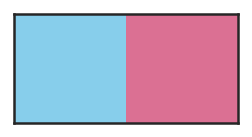

In [11]:
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Arial")
set_style()

custom_palette = ['skyblue','palevioletred']
sns.set_palette(custom_palette)
sns.palplot(custom_palette)

In [14]:
plot_adrs = df_prr_mean.sort_values(by='diff').get('adr').values[-16:]
df = df_prr_mean.query('adr in @plot_adrs')
df = assign_adr_name(df)
df = df.sort_values(by='prior')
df = df.melt(id_vars=['adr_name','sex'], value_vars=['prior','post'], var_name='type', value_name='PRR')

/home/pc2800/envs/sex_risks/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pc2800/envs/sex_risks/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
order

['Balanitis candida',
 'Benign prostatic hyperplasia',
 'Biopsy endometrium abnormal',
 'Biopsy ovary',
 'Gestational diabetes',
 "Mueller's mixed tumour",
 'Ovarian dysgerminoma stage unspecified',
 'Ovarian failure postoperative',
 'Ovarian haematoma',
 'Penis carcinoma recurrent',
 'Prostatic acid phosphatase increased',
 'Salpingostomy',
 'Testicular failure primary',
 'Uterine mass',
 'Vaginal pessary insertion',
 'Vulval haematoma']

In [26]:
order = list(np.unique(df.get('adr_name').values))

for name in ['Prostatic acid phosphatase increased',
             'Biopsy ovary',
             'Vaginal pessary insertion',
             'Balanitis candida',
             'Benign prostatic hyperplasia',
             'Gestational diabetes',
             'Vulval haematoma',
             'Ovarian failure postoperative', 
             'Penis carcinoma recurrent',
             'Uterine mass']: 
    order.remove(name)
    order.append(name)

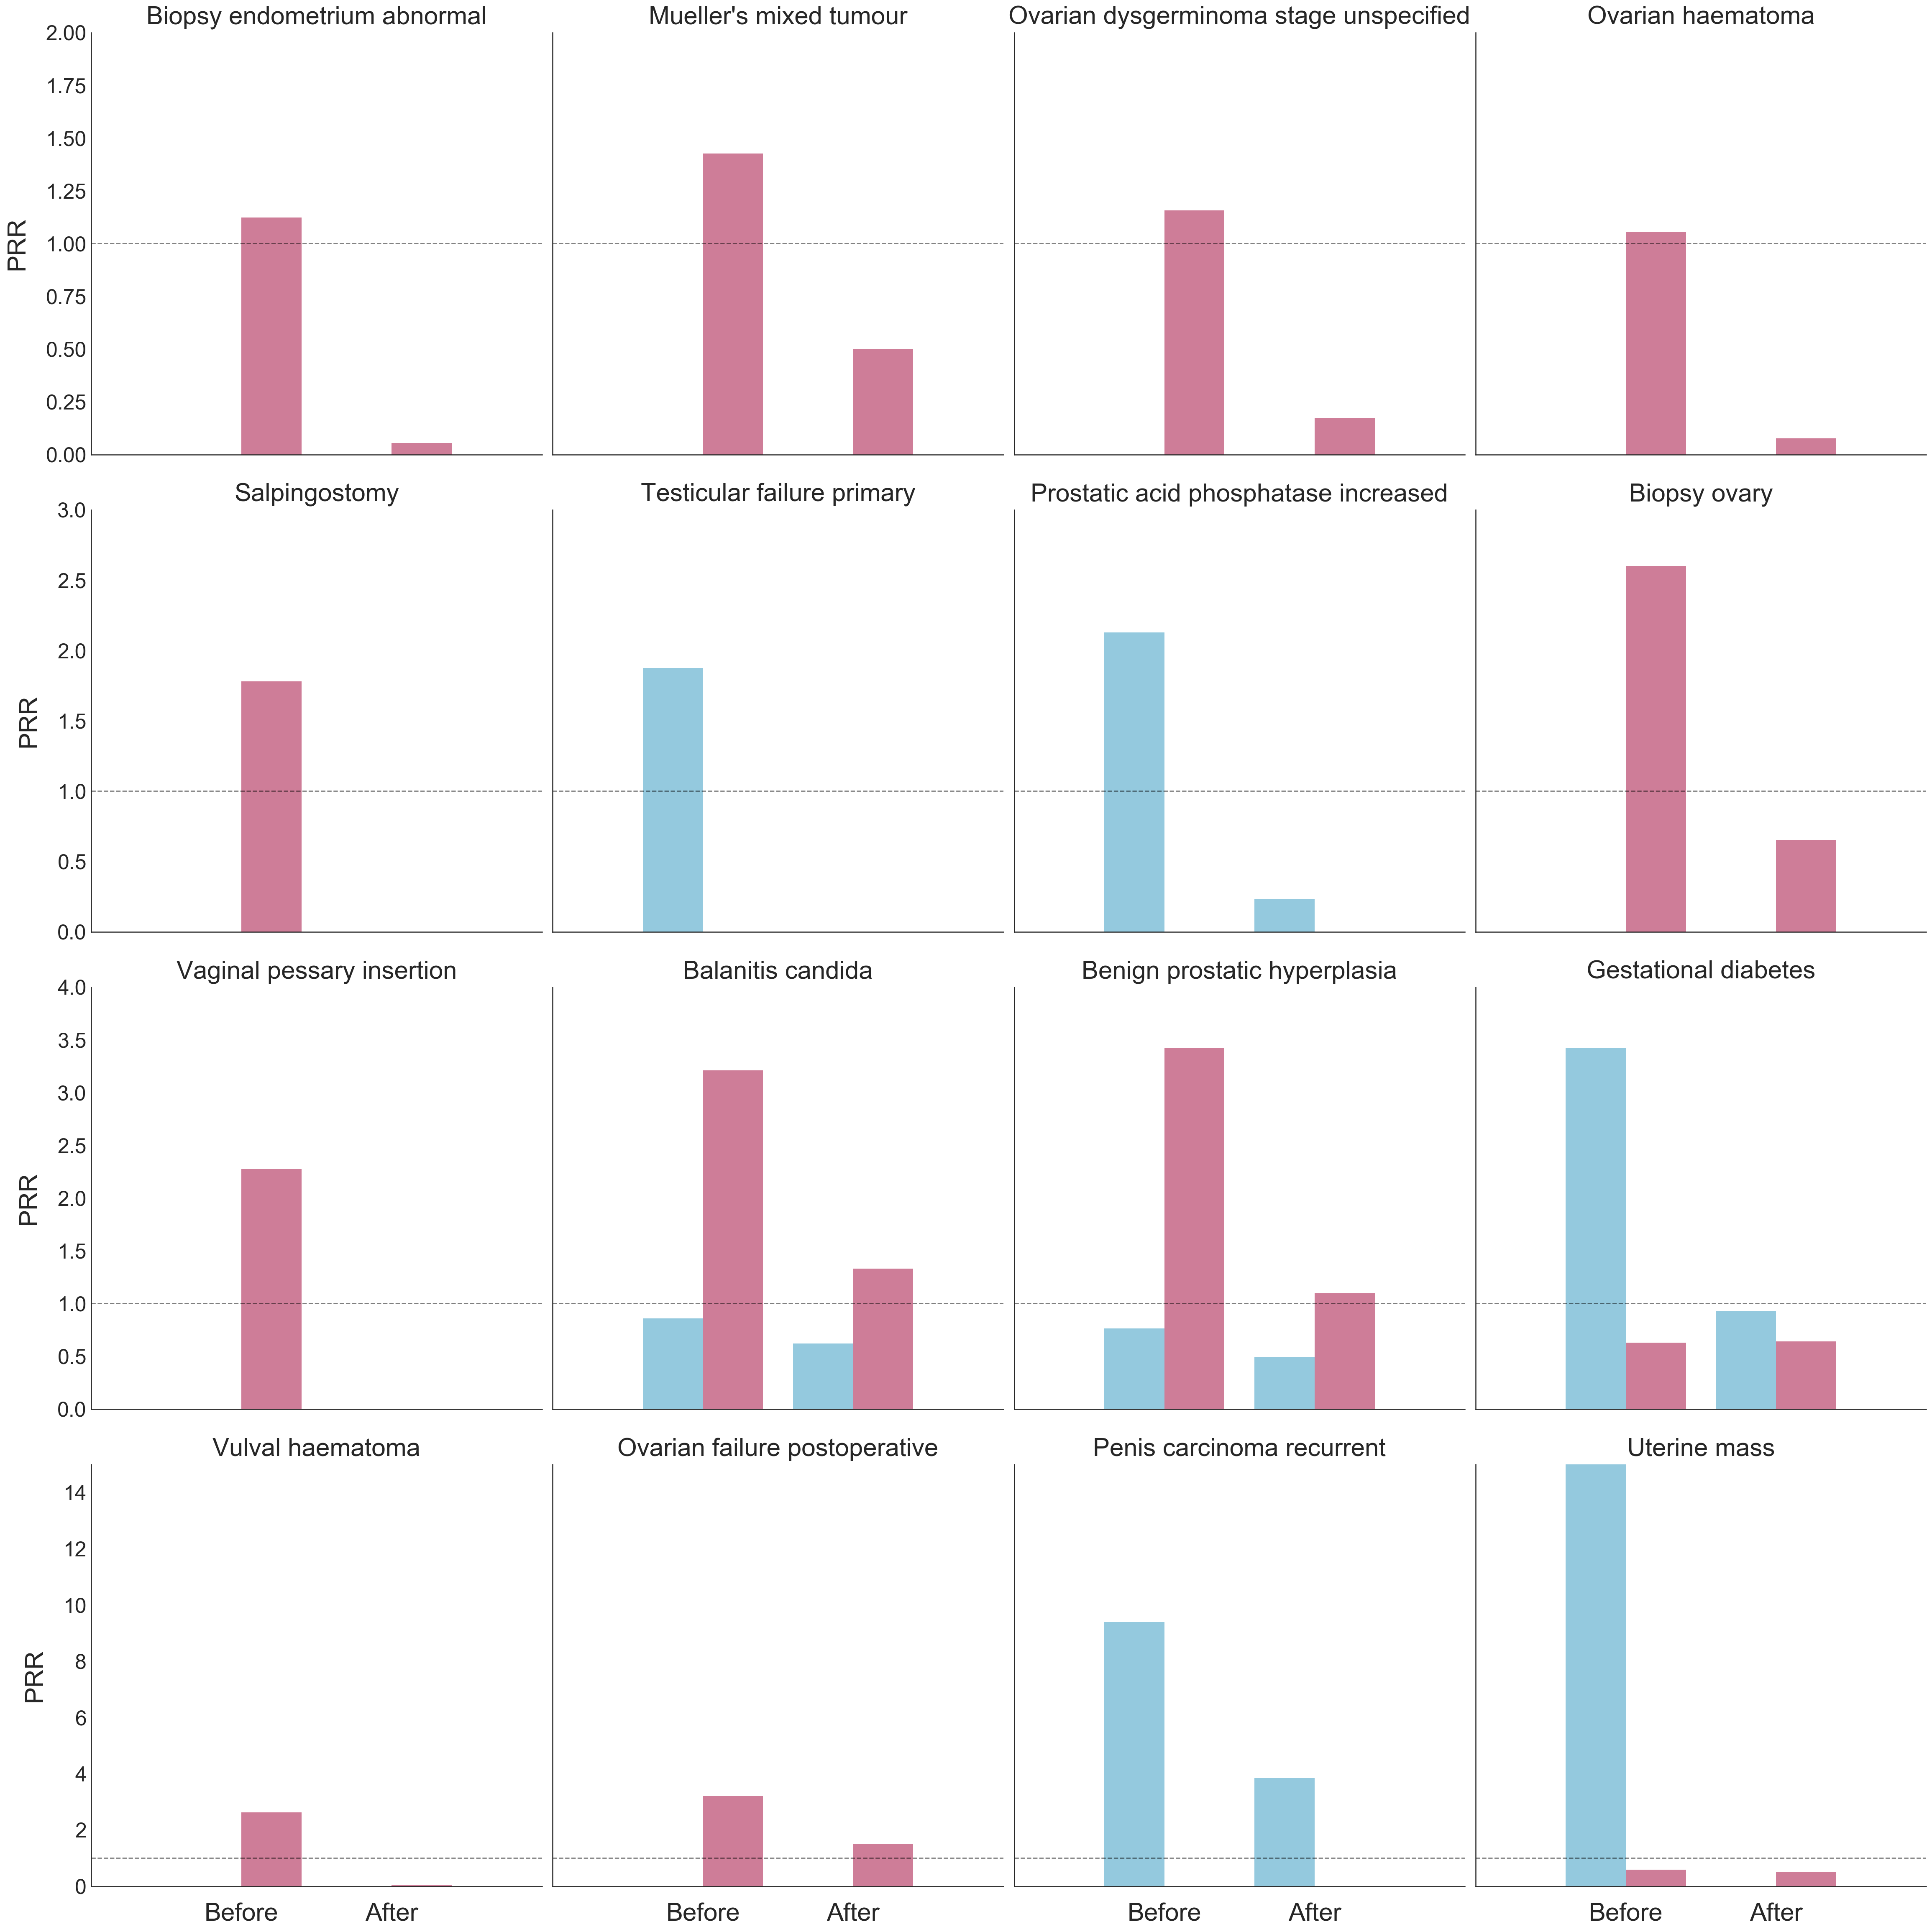

In [27]:
col_wrap=4

g = sns.catplot(
    x='type',
    y='PRR',
    hue='sex',
    hue_order = ['M','F'],
    data=df,
    col='adr_name',
    col_wrap=col_wrap,
    col_order = order,
    kind='bar',
    height=8,
    sharex=True,
    sharey=False,
    legend_out=False
)

fs=30
fs2=25
g.set_titles('{col_name}',fontsize=fs)
g.set_axis_labels('','PRR')
g.set_ylabels(fontsize=fs)
g.set_xticklabels(['Before','After'],fontsize=fs)

x_lim = (-1,2)
for ax in g.axes: 
    ax.hlines(1, x_lim[0], x_lim[1], 'k','dashed', alpha=0.5)
    ax.set_xlim(x_lim)


ylims = [2, 3, 4, 15]
for i, (start, end) in enumerate(zip(range(0,16,col_wrap), range(col_wrap,20,col_wrap))):
    for j, ax in enumerate(g.axes[start:end]): 
        ax.set_ylim((0,ylims[i]))
        if ax.get_legend(): 
            ax.get_legend().set_visible(False)
        ax.set_title(ax.get_title(), fontsize=fs, pad=10)
        ax.tick_params('y',labelsize=fs2)
        if j!=0: 
            ax.yaxis.set_visible(False)
        else:
            ax.set_ylabel('PRR',labelpad=20)

for ax in g.axes[-4:]: 
    ax.tick_params('x',pad=20)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()